# OSMnx overview: querying, simplifying, visualizing, saving

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  
Once you've perused the [features demo notebook](00-osmnx-features-demo.ipynb), this notebook demonstrates more details on querying for place boundaries and street networks, visualizing, and saving models to disk.

# OSMnx 개요: 쿼리, 단순화, 시각화, 저장

저자: [제프 보잉](https://geoffboeing.com/)

   - [OSMnx 개요](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
   - [GitHub 저장소](https://github.com/gboeing/osmnx)
   - [예제, 데모, 자습서](https://github.com/gboeing/osmnx-examples)
   - [문서](https://osmnx.readthedocs.io/en/stable/)
   - [저널 기사/인용](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  
[기능 데모 노트북](00-osmnx-features-demo.ipynb)을 숙독하면 이 노트북은 장소 경계 및 거리 네트워크 쿼리, 시각화 및 디스크에 모델 저장에 대한 자세한 내용을 보여줍니다.

In [1]:
import geopandas as gpd
import osmnx as ox

%matplotlib inline
ox.__version__

'1.5.1'

You can configure OSMnx using the `settings` module. See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.settings) for the settings you can configure. For example, by default OSMnx caches all server responses to prevent repeatedly hitting the server for the same query every time you run it. This both makes our code faster on subsequent runs and helps us be a "good neighbor" to the server. But you can turn caching off (or back on again) with the `use_cache` setting.

`settings` 모듈을 사용하여 OSMnx를 구성할 수 있습니다. 구성할 수 있는 설정은 [문서](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.settings)를 참조하세요. 예를 들어, OSMnx는 기본적으로 모든 서버 응답을 캐시하여 실행할 때마다 동일한 쿼리에 대해 서버에 반복적으로 도달하는 것을 방지합니다. 이것은 후속 실행에서 코드를 더 빠르게 만들고 서버의 "좋은 이웃"이 되는 데 도움이 됩니다. 하지만 `use_cache` 설정으로 캐싱을 끄거나 다시 켤 수 있습니다.

In [2]:
# turn response caching off
ox.settings.use_cache = False

# turn it back on and turn on/off logging to your console
ox.settings.use_cache = True
ox.settings.log_console = False

## Part 1: get place boundaries from OpenStreetMap

OSMnx lets you download place boundary geometries from OpenStreetMap, project them, and plot them. For a more in-depth demonstration of querying by place, see [this notebook](03-graph-place-queries.ipynb).

1부: OpenStreetMap에서 장소 경계 가져오기



OSMnx를 사용하면 OpenStreetMap에서 장소 경계 기하학을 다운로드하고 투영하고 플롯할 수 있습니다. 장소별 쿼리에 대한 자세한 데모는 [이 노트북](03-graph-place-queries.ipynb)을 참조하세요.

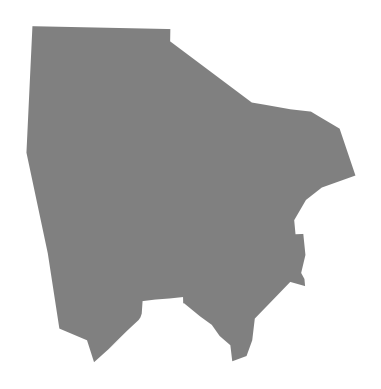

In [3]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("동자동, 남영동, 용산구, 서울, 04320, 대한민국")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")

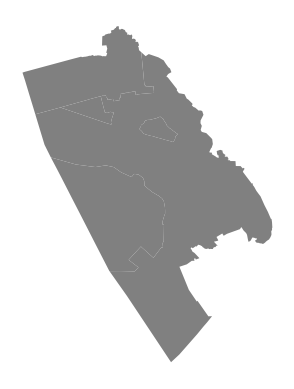

In [4]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
place_names = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
east_bay = ox.geocode_to_gdf(place_names)
east_bay.to_file("./data/east_bay.gpkg", driver="GPKG")
east_bay = ox.project_gdf(east_bay)
ax = east_bay.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [5]:
# if you know the OSM ID of the place(s) you want, you can query it directly
ox.geocode_to_gdf(["R357794", "N8170768521", "W427818536"], by_osmid=True)

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((135.55901 35.13689, 135.55907 35.136...",35.321221,34.874916,135.878442,135.559006,298149575,relation,357794,35.021041,135.755607,"Kyoto, Kyoto Prefecture, Japan",boundary,administrative,0.653138
1,POINT (13.38882 52.51699),52.521988,52.511988,13.393820,13.383820,82949145,node,8170768521,52.516988,13.388820,"Unter den Linden, Friedrichstraße, Dorotheenst...",railway,station,0.000010
2,"POLYGON ((-73.98141 40.76846, -73.98135 40.768...",40.800314,40.764745,-73.949606,-73.981408,202812447,way,427818536,40.782773,-73.965363,"Central Park, New York County, New York, Unite...",leisure,park,0.565172


## Part 2: download and model street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or GeoPackages for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](03-graph-place-queries.ipynb).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

OSMnx를 사용하면 거리 네트워크 데이터를 다운로드하고 위상적으로 수정된 거리 네트워크를 구축하고 네트워크를 투영 및 플로팅하며 나중에 사용할 수 있도록 거리 네트워크를 SVG, GraphML 파일 또는 GeoPackage로 저장할 수 있습니다. 거리 네트워크는 단방향 방향성을 유지하고 지시합니다. 거리 네트워크 생성에 대한 자세한 데모는 [이 노트북](03-graph-place-queries.ipynb)을 참조하세요.

다음 중 하나를 OSMnx에 제공하여 거리 네트워크를 다운로드할 수 있습니다(아래 예 참조).
   - 경계 상자
   - 위도-경도 + 거리
   - 주소와 거리
   - 지명 또는 지명 목록(자동으로 지오코딩하고 경계를 가져오기 위해)
   - 원하는 거리 네트워크 경계의 폴리곤
   - .osm 형식의 xml 파일

다음과 같이 여러 가지 다른 네트워크 유형을 지정할 수도 있습니다.
   - 'drive' - 운전 가능한 공공 도로를 가져옵니다(서비스 도로는 제외).
   - 'drive_service' - 서비스 도로를 포함하여 운전 가능한 거리를 가져옵니다.
   - 'walk' - 보행자가 사용할 수 있는 모든 거리와 경로를 가져옵니다(이 네트워크 유형은 일방통행성을 무시합니다).
   - '자전거' - 자전거 타는 사람이 사용할 수 있는 모든 거리와 경로를 가져옵니다.
   - 'all' - 비공개 OSM 거리 및 경로를 모두 다운로드합니다(다른 유형을 지정하지 않는 한 기본 네트워크 유형임).
   - 'all_private' - 비공개 액세스를 포함하여 모든 OSM 거리 및 경로를 다운로드합니다.

 #### Method #1, pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box.
 이것은 경계 상자 내의 모든 OSM 노드와 경로에서 네트워크를 구성합니다.

In [6]:
# define a bounding box in San Francisco
north, south, east, west = 37.55, 37.56, 126.96, 126.97

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")

#### Method #2, pass a lat-lng point and bounding box distance in meters
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. 이것은 경계 상자 *n* 미터의 북쪽, 남쪽, 동쪽 및 서쪽 지점을 만든 다음 경계 상자 내의 모든 OSM 노드 및 경로에서 네트워크를 구성합니다.

In [7]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.5541, 126.9698)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="drive")

#### Method #3, pass a lat-lng point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it truncates the network by removing all nodes further than *n* meters from the point along the network.
이것은 경계 상자 *n* 미터의 북쪽, 남쪽, 동쪽 및 서쪽 지점을 만든 다음 경계 상자 내의 모든 OSM 노드 및 경로에서 네트워크를 구성합니다. 그런 다음 네트워크를 따라 지점에서 *n* 미터보다 멀리 있는 모든 노드를 제거하여 네트워크를 자릅니다.

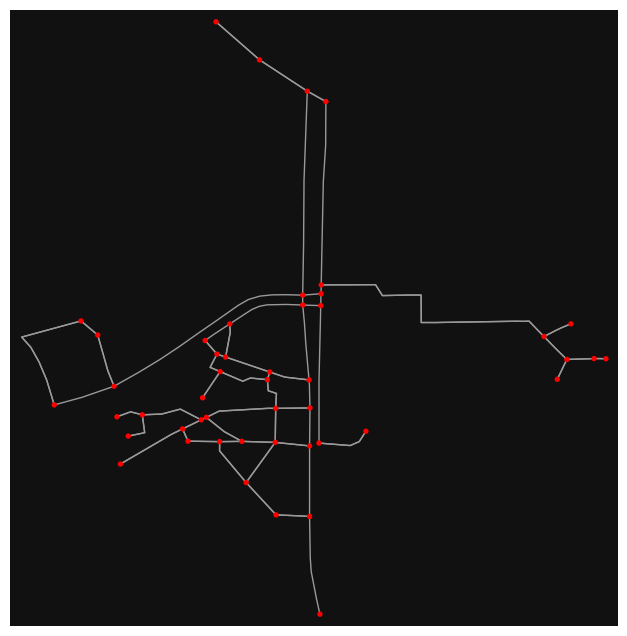

In [8]:
# same point again, but create network only of nodes within 500m along the network from point
G = ox.graph_from_point(location_point, dist=500, dist_type="network")
fig, ax = ox.plot_graph(G, node_color="r")

*Note* the plot above shows the network within 500m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).
*참고* 위의 플롯은 `location_point`에서 500m(네트워크를 따라 이동하는 거리) 이내의 네트워크를 보여줍니다. 기본적으로 `network_type` 매개변수 값은 'all'이며, 이는 특정 유형의 트래픽을 제한하는 경로를 필터링하지 않음을 의미합니다. 이것은 또한 일방통행로가 일방통행으로 존중되며 잘못된 방향으로 내려갈 수 없음을 의미합니다. 따라서 500m는 도로의 허용된 방향으로만 이동하면서 500m 이내에 도달할 수 있는 노드만 고려합니다. 대신(아래) `network_type='walk'`를 지정하여 도보가 허용되는 경로로만 거리 네트워크를 구축할 수 있습니다. 일방 통행로의 인도에서 어느 방향으로든 걸을 수 있기 때문에 이것은 방향이 지정된 네트워크에서 모든 경로를 양방향으로 만듭니다. 따라서 500m는 이제 양방향으로 이동하는 동안 500m 내에서 도달할 수 있는 노드를 고려합니다(일방통행 도로인 경우에도).

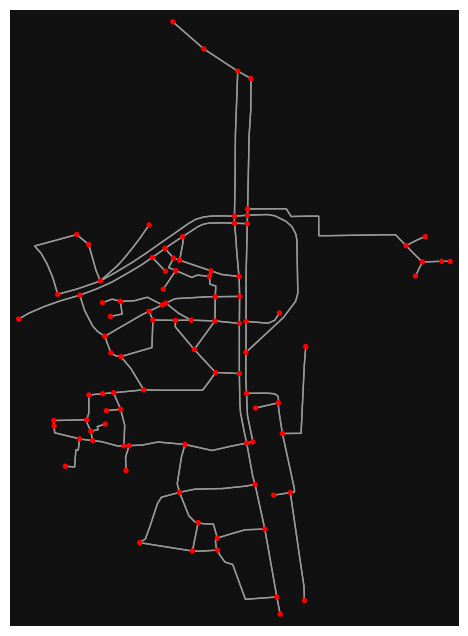

In [9]:
# create network only of nodes within 500m walking along the network from point
G = ox.graph_from_point(location_point, dist=500, dist_type="network", network_type="walk")
fig, ax = ox.plot_graph(G, node_color="r")

#### Method #4, pass an address and distance (*bounding box* or *network*) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then truncates it by network distance (if distance_type='network').
이는 주소를 지오코딩하고 경계 상자를 만들고 네트워크를 다운로드한 다음 네트워크 거리(if distance_type='network')로 잘라냅니다.

In [10]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)

#### Method #5, pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then truncates it to the place's boundary polygon.
이것은 장소 이름을 지오코딩하고 장소의 경계 모양 다각형과 경계 상자를 가져오고 경계 상자 내에서 네트워크를 다운로드한 다음 장소의 경계 다각형으로 자릅니다.

In [11]:
# create the street network within the city of Piedmont's borders
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")

In [12]:
# you can also pass multiple places as a mixed list of strings and/or dicts
places = [
    "Los Altos, California, USA",
    {"city": "Los Altos Hills", "state": "California"},
    "Loyola, California",
]
G = ox.graph_from_place(places, truncate_by_edge=True)

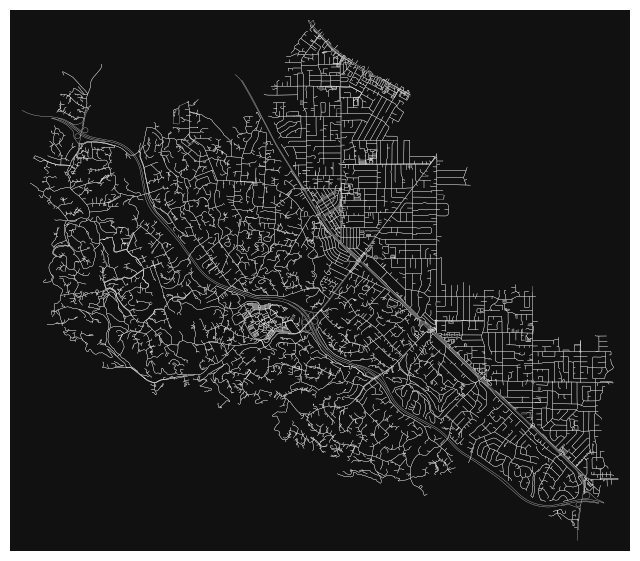

In [13]:
# save to disk as GeoPackage file then plot
ox.save_graph_geopackage(G)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

#### Method #6, pass a polygon ####

This example loads the [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm)'s polygon from a ShapeFile, then downloads the network within its bounding box, then prunes all nodes that lie outside the place's boundary polygon.
이 예는 ShapeFile에서 [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm)의 다각형을 로드한 다음 경계 상자 내에서 네트워크를 다운로드한 다음 모든 노드를 정리합니다. 장소의 경계 다각형 밖에 있습니다.

In [14]:
calif = gpd.read_file("input_data/ZillowNeighborhoods-CA")
mission_district = calif[(calif["CITY"] == "San Francisco") & (calif["NAME"] == "Mission")]
polygon = mission_district["geometry"].iloc[0]

G2 = ox.graph_from_polygon(polygon, network_type="drive_service")

#### Method #7, load a .osm xml file

In [15]:
# create graph from .osm extract file
G = ox.graph_from_xml("./input_data/West-Oakland.osm.bz2")

## Part 3: simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs). For a more in-depth demonstration of topological simplification with OSMnx, see [this notebook](04-simplify-graph-consolidate-nodes.ipynb).
단순화는 일반적으로 내부적으로 OSMnx에 의해 자동으로 수행되지만 작동 방식을 보기 위해 분해할 수 있습니다. OpenStreetMap 노드가 이상합니다. 여기에는 교차로가 포함되지만 도로가 구부러지는 단일 블록을 따라 있는 모든 지점도 포함됩니다. 후자는 그래프 이론의 의미에서 노드가 아니므로 알고리즘적으로 제거하고 "진정한" 네트워크 노드 사이의 에지 세트를 단일 에지로 통합합니다. 엄격함과 비엄격함의 두 가지 단순화 모드가 있습니다. 주요 차이점은 엄격 모드와 달리 비엄격 모드는 "확장 그래프"로 단순화할 수 있다는 것입니다(즉, 그래프가 방향이 없는 경우 입사 에지가 다른 OSM ID를 갖는 한 노드는 차수가 2임). OSMnx를 사용한 토폴로지 단순화에 대한 보다 심층적인 데모는 [이 노트북](04-simplify-graph-consolidate-nodes.ipynb)을 참조하십시오.

In [16]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)

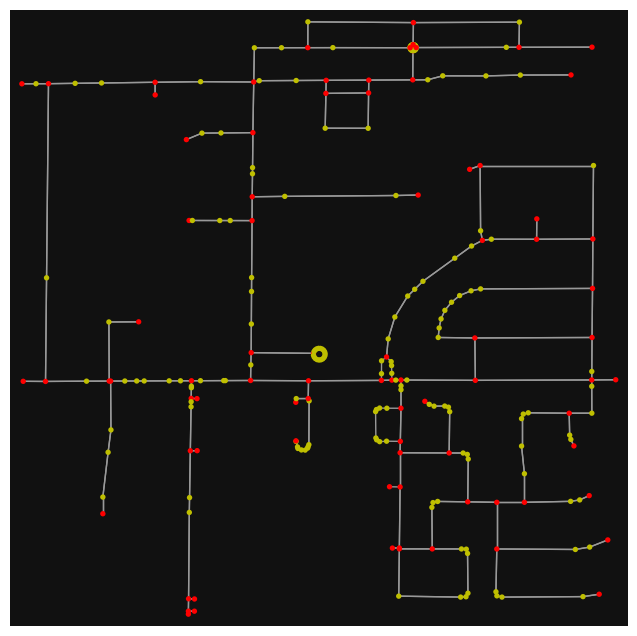

In [17]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

The dots above are OSM nodes. We'll remove the nodes in yellow as they're not real network nodes (intersections/dead-ends).

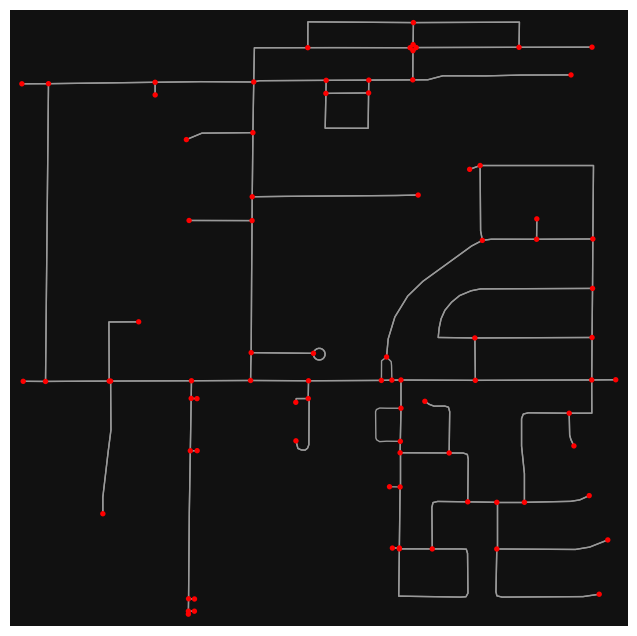

In [18]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color="r")

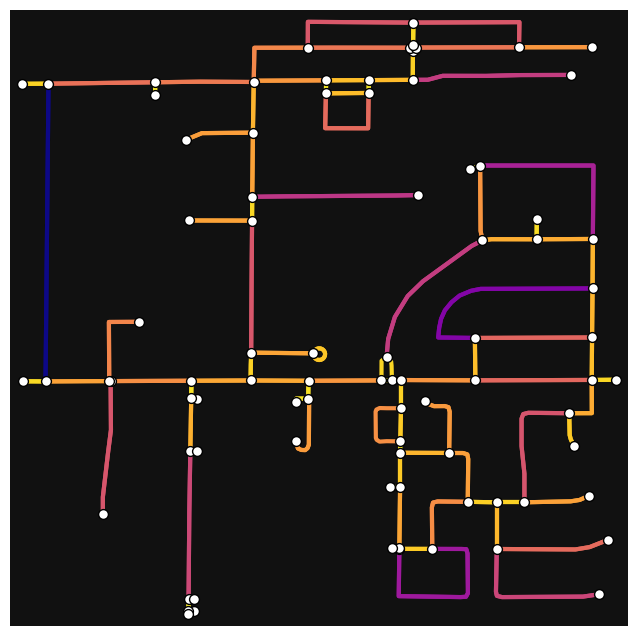

In [19]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

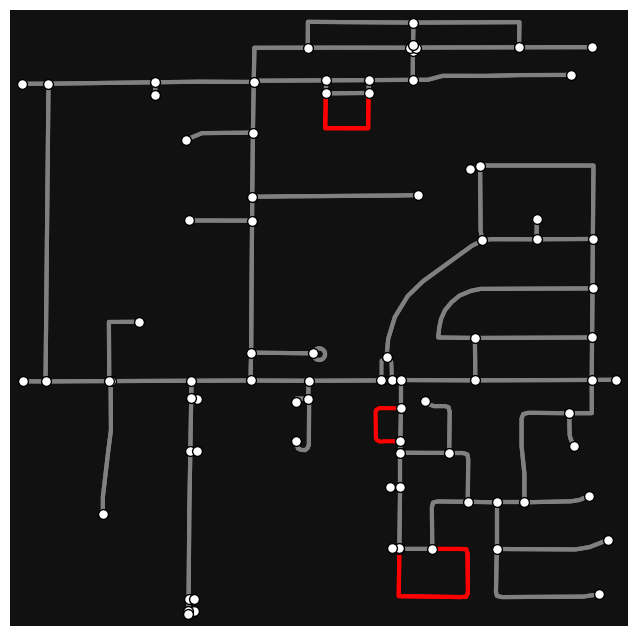

In [20]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

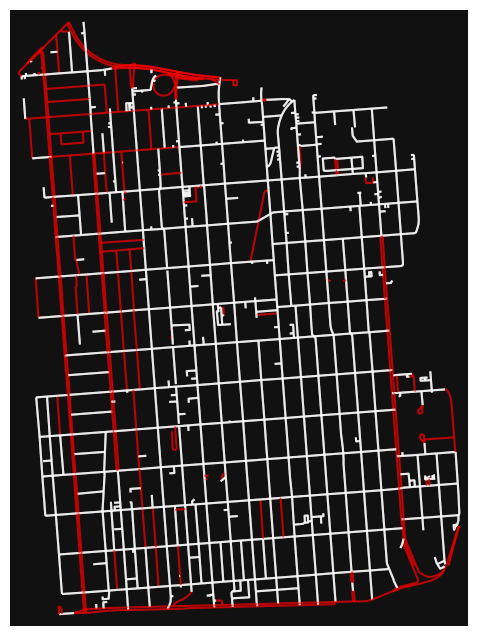

In [21]:
# highlight all one-way edges in the mission district network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G2.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G2, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

## Part 4: saving networks to disk

For more examples of saving and loading networks to/from disk, see [this notebook](05-save-load-networks.ipynb).

In [22]:
# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G, filepath="./data/network.gpkg")

In [23]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G, filepath="./data/network.graphml")

## Part 5: calculate basic network indicators

In [24]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats["circuity_avg"]

1.1358653434380146

In this street network, the streets are ~16% more circuitous than the straight-lines paths would be.

For examples of analyzing street networks, see [this example](06-stats-indicators-centrality.ipynb).